<a href="https://colab.research.google.com/github/DanyloVanin/PercussionHero_BreatheInTheAI/blob/main/BitAI_Spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U --pre tensorflow tensorflow_datasets

# Creating Spectogram from sound


*   [Tensorflow Example](https://www.tensorflow.org/tutorials/audio/simple_audio)
*   [WAV to Spectogram](https://gist.github.com/albertnieto/23af57cf147185ee94cb1b99be51c93e)
*   [How to Easily Process Audio on Your GPU with TensorFlow](https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06)
*   [MelSpectogram & Audio Data Preparation and Augmentation](https://www.tensorflow.org/io/tutorials/audio)
*   [Coursera Course: Audio Signal Processing for Music Applications](https://www.coursera.org/learn/audio-signal-processing)



In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importing test dataset

In [ ]:
# Downloading dataset
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'left' 'stop' 'up' 'right' 'yes' 'down' 'go']


In [ ]:
tf.__version__

'2.11.0-rc2'

In [ ]:
# The audio clips are 1 second or less at 16kHz. 
# The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


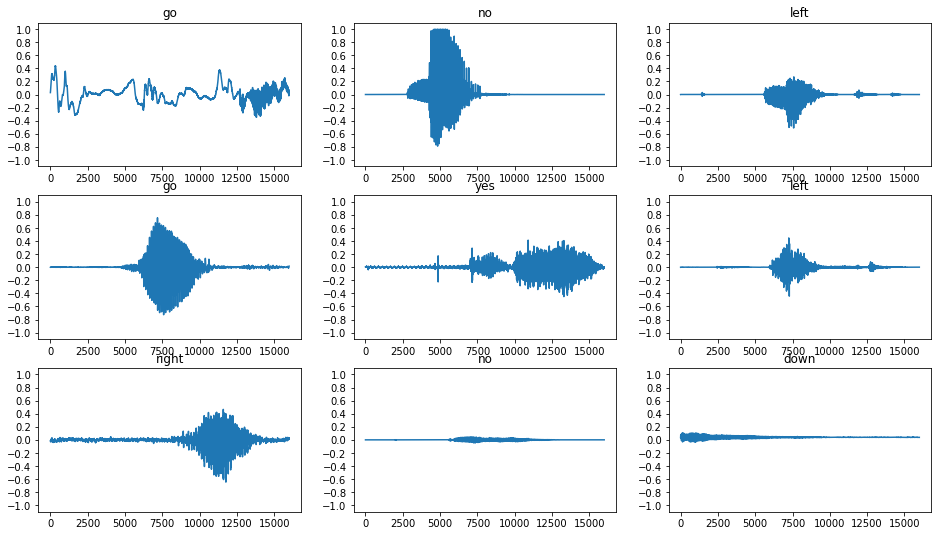

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

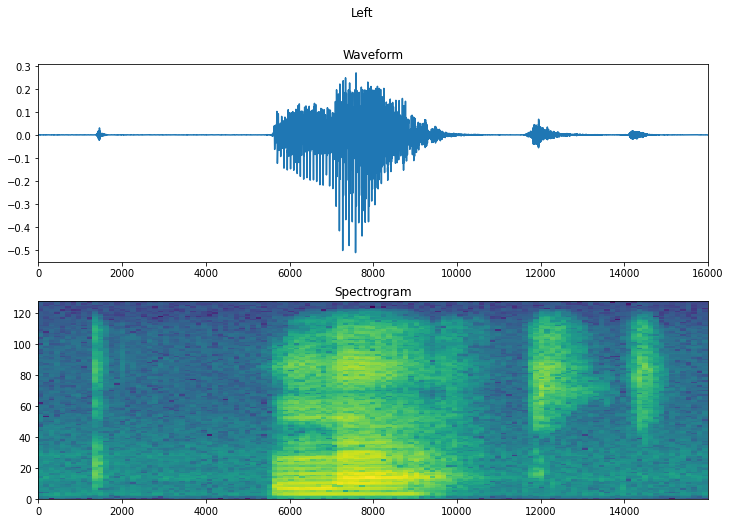

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
%pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 78.8 MB/s 


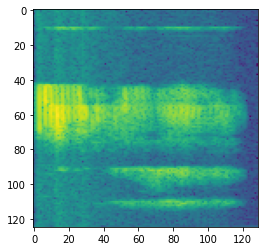

In [ ]:
OUTPUT_DIR = 'output/'

# Convert to spectrogram
spectrogram_tf = tfio.audio.spectrogram(
    example_audio[2], nfft=256, window=255, stride=128)

plt.figure()
plt.imshow(tf.math.log(spectrogram_tf).numpy())
plt.savefig(OUTPUT_DIR+'out.png')

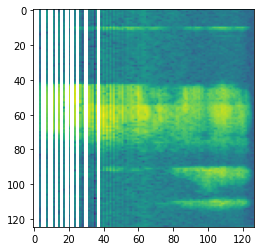

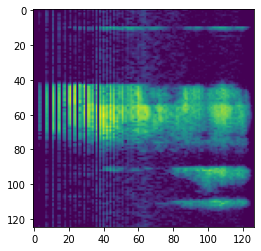

In [ ]:
import tensorflow_io as tfio

# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram_tf, rate=16000, mels=127, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# # Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())